#### Much of this code is adapted from Professor David Stewart's (University of Iowa Dept. of Mathematics) base code: (see stewart_code.ipynb)

In [214]:
using LinearAlgebra
using Plots

## Optimal Fishing Effort

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u \\ \delta m + \beta f u \end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1$


#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [215]:
function F(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
    alpha = get(params, "alpha", 0.1)
    delta = get(params, "delta", 0.05)
    beta = get(params, "beta", 1.0)
    f_max = get(params, "f_max", 1.0)
    f, m = xv 
    dfdt = alpha * f * (f_max - f) - beta * f * u[1]
    dmdt = delta * m + beta * f * u[1]
    func = [dfdt, dmdt]
    return func
end

function g(xv,verbose=0)
    return -xv[2]
end

function dg(xv::Vector{Float64}, verbose=0) 
    return [0.0, -1.0]
end

dg (generic function with 2 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{u}$
$\quad$ $\nabla_{u} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} -\beta f \\ \beta f \end{bmatrix}$

In [237]:
function dFdu(xvect::Vector{Float64},u::Vector{Float64},params::Dict{String,Real},verbose=0,n_eqs=2)
    f = xv[1]
    beta = get(params, "beta", 1.0)
    grad = [-beta * f, beta * f]
    return reshape(grad,n_eqs,1)
end

dFdu (generic function with 3 methods)

#### Derivative of $\textbf{F}$ with respect to $\textbf{x}$
$\quad$ $\nabla_{x} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} \alpha -2 \alpha f - u  && 0  \\ u  && \delta \end{bmatrix}$

In [238]:
function dFdx(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
    f = xv[1]
    alpha = get(params, "alpha", 1.0)
    beta = get(params, "beta", 1.0)
    delta = get(params, "delta", 0.05)
    fmax = get(params, "fmax", 1.0)
    jacobian = [   alpha * fmax - 2 * alpha * f - beta * u[1]        0     ;  
                              beta * u[1]                          delta      ]
    return jacobian
end

dFdx (generic function with 2 methods)

#### Discretization via Euler's Method
$\quad$ $\textbf{x}_{k+1} = \textbf{x} + h\textbf{F}(\textbf{x}_{k},\textbf{u}_{k})$

This allows us to find $\textbf{x}(T)$ via a forward pass

In [239]:
function forwardstep(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,params::Dict{String,Real},verbose=0,n_eqs=2)
    N = size(u,n_eqs) # number of cols of u
    n = length(xv)
    xs = zeros(eltype(xv),n,N+1)
    xs[:,1] = xv
    h = get(params,"h",0.1)
    count = 0
    for i = 0:N-1
        xs[:,i+2] = xs[:,i+1] + h*F(t0+i*h,xs[:,i+1],u[:,i+1],params)
    end
    xs
end

forwardstep (generic function with 3 methods)

#### Lagrange Multiplier Equations
$\quad$ $\lambda_{k-1} = \lambda_{k} + h\nabla_{x} \textbf{F}(\textbf{x}_k, \textbf{u}_k)^T \lambda$

Moving backwards from the last $\lambda$ fills in the rest of the $\lambda$'s via a backward pass

In [240]:
# filling in the lagrange multipliers 
function adjointstep(λend::Vector{Float64},t0::Float64,xv::Matrix{Float64},u::Matrix{Float64},dFdx::Function,params::Dict{String,Real},verbose=0,n_eqs=2)
    N = size(u,n_eqs)
    n = length(λend)
    λs = zeros(eltype(λend),n,N)
    λs[:,N] = λend
    count = 0
    h = get(params,"h",0.1)
    for i = N-2:-1:0
        λs[:,i+1] = λs[:,i+2] + h*dFdx(t0+i*h,xv[:,i+1],u[:,i+1],params)'*λs[:,i+2]
    end
    λs
end

adjointstep (generic function with 3 methods)

#### Objective function
$\quad$ $g(\textbf{x}_N)=G(\textbf{u}_{0}, \textbf{u}_{1}, ... , \textbf{u}_{N-1})$

where $g(\textbf{x}_k)$ is the output at each step $k$

In [241]:
function G(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,g::Function,params::Dict{String,Real},verbose=0)
    xs = forwardstep(t0,xv,u,F,params)
    return g(xs[:,end])
end

G (generic function with 2 methods)

#### Gradient of objective function with respect to $\textbf{u}$
$\quad$ $\nabla_{u_{k}} g(\textbf{x}_{N}) = h\nabla_{u}\textbf{F}(\textbf{x}_{k}, \textbf{u}_{k})^T \lambda_{k}$

In [242]:
function dG(t0::Float64,xv::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,dg::Function,params,verbose=0)
    h = get(params, "h", 0.1)
    xs = forwardstep(t0,xv,u,F,params)
    λend = dg(xv[:,end])
    λs = adjointstep(λend,t0,xs,u,dFdx,params)
    dGval = zeros(eltype(u),size(u,1),size(u,2))
    for i = 0:size(u,2)-1
        dGval[:, i+1] = h*dFdu(xs[:, i+1],u[:,i+1],params)'*λs[:, i+1]
    end
    dGval
end

dG (generic function with 2 methods)

#### Projection of controls onto $\space \mathcal{U}$
$\quad$ Search direction: $\textbf{d}=[(\textbf{d}_{0})^T, (\textbf{d}_{2})^T, ... , (\textbf{d}_{N-1})^T]^T$\
$\quad$ New control: $\textbf{u}^{+}(\alpha) = Proj_{\mathcal{U}}(\textbf{u}+\alpha \textbf{d})$, $\space$ $\mathcal{U}$ convex

This is to incorporate the constraints $\textbf{u}_{k} \in U \space \forall k$

In [243]:
function proj_u(u,a,b)
    clamp.(u, a, b)
end

proj_u (generic function with 1 method)

#### Optimal Control Algorithm
Performs gradient descent in conjunction with backtracking line search on the iterates of $\textbf{u}$

In [244]:
function gradient_descent(u,s,dGval,proj)
    return proj(u-s*dGval)
end

gradient_descent (generic function with 1 method)

In [288]:
function optcontrol(t0::Float64,x0::Vector{Float64},u::Matrix{Float64},F::Function,dFdx::Function,dFdu::Function,g::Function,dg::Function,proj::Function,params::Dict{String,Real},ulist=nothing,trace=0)
    Gval = G(t0,x0,u,F,g,params,1)
    Gvalold = Gval
    dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,1)
    firsttime = true
    iter = 0
    c1 = get(params, "c1", 0.01)
    s0 = get(params, "s0", 1.0)
    h = get(params, "h", 0.1)
    maxiter = get(params, "maxiter", 10000)
    eps = get(params, "eps", 0.4)
    if ulist != nothing
        push!(ulist,u)
    end
    while ( firsttime || (abs(Gvalold - Gval) > eps) ) && (iter < maxiter)
        # println("========================")
        # println("iter: ", iter)
        # println("Initial Gval: ", Gval)
        # println("Initial u: ", u)
        Gvalold = Gval
        s = s0
        unew = gradient_descent(u,s,dGval,proj) # projected gradient descent
        Gval = G(t0,x0,unew,F,g,params,1)      
        # println("New u: ", unew)
        while Gval > Gvalold + c1*dot(dGval,unew-u) && s > 1e-6*s0
            s = s / 2
            unew = gradient_descent(u,s,dGval,proj)
            Gval = G(t0,x0,unew,F,g,params,1)
            dGval = dG(t0,x0,unew,F,dFdx,dFdu,dg,params,0)
        end
        u = unew
        firsttime = false
        dGval = dG(t0,x0,u,F,dFdx,dFdu,dg,params,0)
        # println("New Gval: ", Gval)
        # println("Diff: ", abs(Gvalold - Gval))
        # println("eps: ",eps)
        # println(abs(Gvalold - Gval) > eps)
        if ulist != nothing
            push!(ulist,u)
        end
        iter += 1
    end
    (u,iter)
end

optcontrol (generic function with 3 methods)

In [289]:
function optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg,n_eqs=2)
    println(typeof(u))
    println(typeof(xv))
    xs = forwardstep(t,xv,u,F,params,0,n_eqs)
    println("finished forward step")
    λend = dg(xs[:,end])
    println("computed λend")
    λs = adjointstep(λend,t,xs,u,dFdx,params,0,n_eqs)
    print("finished adjoint step")
    ulist = []
    u = fill(0.0, 1,N)
    opt_u,iters = optcontrol(t,xv,u,F,dFdx,dFdu,g,dg,u->proj_u(u,-1.0,1.0),params,ulist,0)
    return opt_u, iters
end

optimize (generic function with 2 methods)

#### Initial Parameters #1:
$\quad$ $T = 20\space years, \alpha = 0.1/year, \delta = 0.05/year, u_{max}=0.5, N=200, h=0.1$

In [330]:
xv  = [0.9; 0.0]
t = 0.0; 
N = 200
u = zeros(1,N)
T = 20 
h = T/N
params = Dict(
    "alpha"=>0.5,
    "delta"=>0.05,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-4,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>1000,
    "s"=>0.1
)

Dict{String, Real} with 10 entries:
  "eps"     => 0.0001
  "c1"      => 0.05
  "s"       => 0.1
  "f_max"   => 1.0
  "maxiter" => 1000
  "alpha"   => 0.5
  "s0"      => 1.0
  "h"       => 0.1
  "delta"   => 0.5
  "beta"    => 1.0

In [331]:
opt_u, iters = optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg)

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

([1.0 1.0 … 0.09450008931112137 0.09000008583068848], 2)

In [332]:
opt_u

1×200 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  0.0992251  0.0945001  0.0900001

In [333]:
xsopt = forwardstep(t,xv,opt_u,F,params)

2×201 Matrix{Float64}:
 0.9  0.8145  0.740604  0.67615   …      0.000363542      0.00037844
 0.0  0.09    0.17595   0.258808     11625.6          12206.9

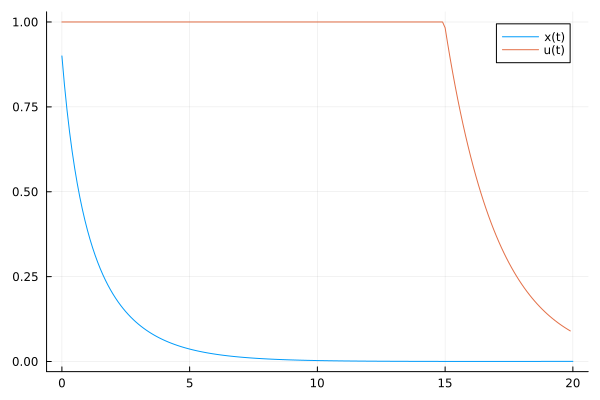

In [334]:
using Plots
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

#### Initial Parameters #2:
$\quad$ $T = 20\space years, \alpha = 0.05/year, \delta = 0.1/year, u_{max}=0.5, N=200, h=0.1$

In [298]:
xv  = [0.9; 0.0]
t = 0.0; 
N = 200
u = zeros(1,N)
T = 20 
h = T/N
params = Dict(
    "alpha"=>0.05,
    "delta"=>0.1,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>h,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>1000,
    "s"=>0.1
)
u_test = zeros(1,N)
dxv = 1e-3*[0.7; -0.7]
println(dxv)
du = 1e-3*(ones(1,N) * 0.7)
# F(t::Float64, xv::Vector{Float64}, u::Vector{Float64}, params::Dict{String,Real}, verbose=0)
@show (F(t,xv+dxv,vec(u),params)-F(t,xv-dxv,vec(u),params)-2dFdx(t,xv,vec(u),params)*dxv)/norm(dxv)
@show (F(t,xv,vec(u+du),params)-F(t,xv,vec(u-du),params)-(2*dFdu(xv,vec(u),params)*du)[:,1])/norm(du)
@show (g(xv+dxv)-g(xv-dxv)-2*dot(dg(xv),dxv))/norm(dxv)

[0.0007, -0.0007]
((F(t, xv + dxv, vec(u), params) - F(t, xv - dxv, vec(u), params)) - (2 * dFdx(t, xv, vec(u), params)) * dxv) / norm(dxv) = [-2.23833458596189e-15, 0.0]
((F(t, xv, vec(u + du), params) - F(t, xv, vec(u - du), params)) - (2 * dFdu(xv, vec(u), params) * du)[:, 1]) / norm(du) = [-2.1904191666905346e-17, 0.0]
((g(xv + dxv) - g(xv - dxv)) - 2 * dot(dg(xv), dxv)) / norm(dxv) = 0.0


0.0

In [299]:
opt_u, iters = optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg)

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

([1.0 1.0 … 0.6193753760461216 0.6300000858306884], 8)

In [300]:
xsopt = forwardstep(t,xv,opt_u,F,params)

2×201 Matrix{Float64}:
 0.9  0.81045  0.730173  0.658141  …  1.54189e-5  1.45409e-5  1.36976e-5
 0.0  0.09     0.171945  0.246682     5.9859      6.04576     6.10622

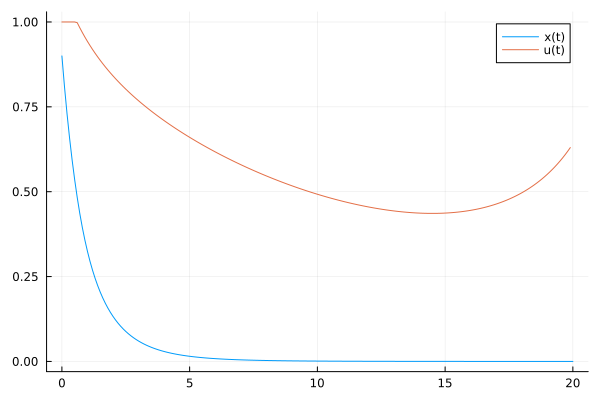

In [301]:
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

#### Repeating with N = 400 with T = 20 years to see any effects due to the discretization of the problem.

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

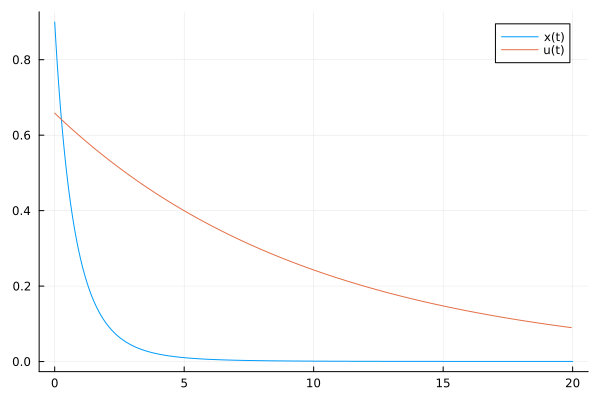

In [306]:
xv  = [0.9; 0.0]
t = 0.0; 
N = 400
u = zeros(1,N)
T = 20 
h = T/N
params = Dict(
    "alpha"=>0.1,
    "delta"=>0.05,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-4,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>1000,
    "s"=>0.1
)

opt_u, iters = optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg)
xsopt = forwardstep(t,xv,opt_u,F,params)
plot(h*(0:N),xsopt[1,:],label="x(t)")
plot!(h*(0:N-1),opt_u[1,:],label="u(t)")

#### Repeating with N = 400 with T = 40 years to see any effects due to the finite time interval.

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

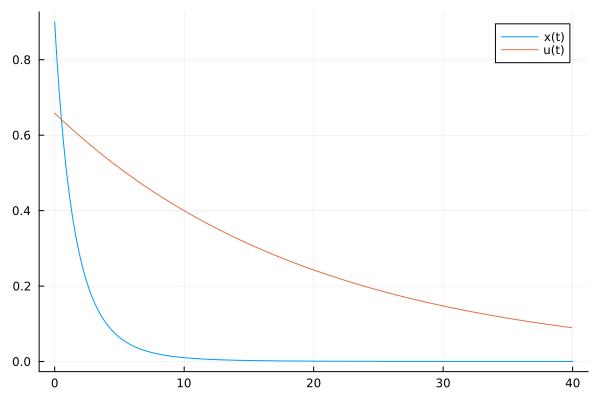

In [309]:
xv  = [0.9; 0.0]
t = 0.0; 
N = 400
u = zeros(1,N)
T = 40 
h = T/N
params = Dict(
    "alpha"=>0.1,
    "delta"=>0.05,
    "beta"=>1.0,
    "f_max"=>1.0,
    "h"=>0.1,
    "eps"=>1e-4,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>1000,
    "s"=>0.1
)

opt_u, iters = optimize(xv,t,N,u,T,params,F,dFdx,dFdu,g,dg)
xsopt = forwardstep(t,xv,opt_u,F,params)
plot(0.1*(0:N),xsopt[1,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")

## Optimal Fishing Effort - Addition of Predator

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u - \gamma f s\\ \gamma f s - \rho s \\ \delta m + \beta f u\end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1, \rho = 1, \alpha = 0.1, \gamma = 5$

#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ s \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ s \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 0 \\ -1 \end{bmatrix}$

In [340]:
function dFdx_pred(t, xv, u, params)
    alpha = get(params, "alpha", 0.1)
    delta = get(params, "delta", 0.05)
    beta = get(params, "beta", 1.0)
    gamma = get(params, "gama", 5.0)
    rho = get(params, "rho", 1.0)
    f = xv[1]
    s = xv[2]
    return [alpha - 2*alpha*f - beta * u[1]     -gamma*f         0;
                   gamma * s                   -rho              0;
                  beta * u[1]                    0               delta ]
end


function F_pred(t, x, u, params, verbose=0)
    f, s, m = x
    alpha = get(params,"alpha",0.1)
    delta = get(params,"delta",0.05)
    dfdt = alpha * f * (1 - f) - f* u[1] - 5 * f * s
    dsdt = 5 * f * s - s
    dmdt = delta * m + u[1] * f
    return [dfdt, dsdt, dmdt]
end

function g_pred(xv,verbose=0)
    return -xv[3]
end

function dg_pred(xv, verbose=0) 
    return [0.0, 0.0, -1.0]
end

function dFdu_pred(xvect::Vector{Float64},u::Vector{Float64},params::Dict{String,Real},verbose=0)
    f = xv[1]
    beta = get(params, "beta", 1.0)
    grad = [
        -beta * f, 
            0, 
        beta * f
    ]
    return reshape(grad,3,1)
end

dFdu_pred (generic function with 4 methods)

In [341]:
xv  = [0.9; 0.0]
t = 0.0; 
N = 200
u = zeros(3,N)
T = 20 
h = T/N
params = Dict(
    "alpha"=>0.05,
    "delta"=>0.1,
    "beta"=>1.0,
    "rho"=>1.0,
    "gamma"=>5.0,
    "f_max"=>1.0,
    "h"=>h,
    "eps"=>1e-2,
    "s0"=>1.0, 
    "c1"=>0.05,
    "maxiter"=>1000,
    "s"=>0.1
)

opt_u,iters = optimize(xv2,t,N,u2,T,params,F_pred,dFdx_pred,dFdu_pred,g_pred,dg_pred,3)

Matrix{Float64}
Vector{Float64}
finished forward step
computed λend
finished adjoint step

([1.0 1.0 … 0.662038186853914 0.6750000858306885], 9)

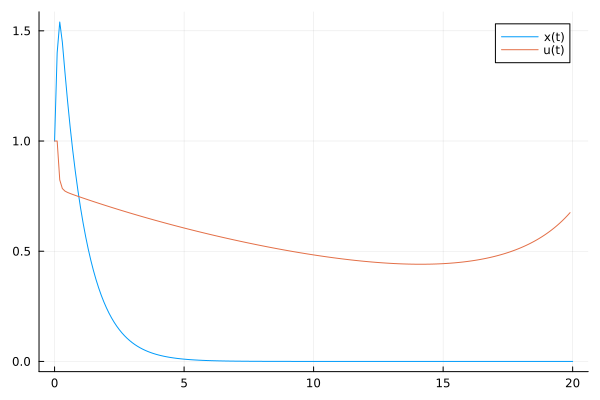

In [342]:
xsopt = forwardstep(t,xv2,opt_u,F_pred,params)
plot(0.1*(0:N),xsopt[2,:],label="x(t)")
plot!(0.1*(0:N-1),opt_u[1,:],label="u(t)")